# Team Introduction
Our group is comprised of Braden Anderson, Hien Lam, and Tavin Weeda.

In [18]:
# import libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

In [7]:
# read df here
df = pd.read_csv("./Collision_Dataset_Imputed_06042022.csv")

# Overview
We would like to predict injury severity of the 2021 vehicular accident data. This is a classification problem in which effectiveness will ultimately be measured based on accuracy. 

Our plan of action:
1. Finalize features, one hot encode as necessary
2. Conduct feature selection
3. Using an 80/20 train/test split, perform gridsearches with cross validation on scaled features (did we do 10-fold cv? if so, mention it). Specifically, gridsearches for SVC and SGDClassifier
4. Elucidate the best performing models with highest accuracy and ascertain its accuracy on the hold out test set
5. Interpret the feature importance from logistic regression
6. Interpret support vectors
7. Discuss the pros and cons of each model as it relates to classification
8. Conclude with our findings

## Finalize the features and other post-EDA work

#### Plot Functions

In [12]:
# Helper function to plot_feature_counts_by_grouping_level
def _set_patch_colors(ax, text_to_color_map):
    
    x_text_objects = ax.get_xticklabels()
    x_tick_positions = ax.get_xticks()
    
    text_to_coordinate_map = {x_text_obj.get_text():x_pos for x_text_obj, x_pos in zip(x_text_objects, x_tick_positions)}
    
    # Iterate across the x-tick text labels
    for text, text_x_pos in text_to_coordinate_map.items():
        
        # Grab the color associated with this text label
        color = text_to_color_map[text]
        
        # Iterate over the patches object, find the one at the location
        # that needs to be color next, then color it.
        for p in ax.patches:
            patch_x_pos = p.get_x()
            patch_width = p.get_width()
            patch_text_location = patch_x_pos + (patch_width/2)
            
            # If this is the location that needs to be colored next
            if patch_text_location == text_x_pos:
                p.set_color(c=color)
    
    return 

# Helper function to plot_feature_counts_by_grouping_level
def _get_text_to_color_map(ax, all_plot_column_levels, palette="husl"):
    
    # X-axis text objections
    x_text_objects = ax.get_xticklabels()
    
    # Color palette with one color for each level in the feature being plotted
    color_palette = sns.color_palette(palette=palette, n_colors=len(all_plot_column_levels))
    
    # Map axis label text --> color
    text_to_color_map = {x_text_obj.get_text():color for x_text_obj, color in zip(x_text_objects, color_palette[:len(x_text_objects)])}

    # Handling the one-off situation where the color map is going to be too short
    if len(text_to_color_map) < len(all_plot_column_levels):
        missing_levels = [column_name for column_name in all_plot_column_levels if column_name not in text_to_color_map]
        for index, level in enumerate(missing_levels):
            text_to_color_map[level] = color_palette[index]
    
    return text_to_color_map

# Helper function to plot_feature_counts_by_grouping_level
def _add_count_plot_annotations(ax, annot_vshift, round_digits, annot_fontsize, annotation_values=None):

    # Annotate the percentages on top of the bars
    for index, p in enumerate(ax.patches): 
            
        if annotation_values is not None:
            annot_value = annotation_values[index]
        else:
            # Percentage is the ratio of the bar height over the total people
            annot_value = f"{round((100 * (p.get_height() / num_observations)), round_digits)}%"

        # Annotate on the left edge of the bar
        x = p.get_x()
        
        # Annotate just above the top of the bar
        y = p.get_y() + p.get_height() + annot_vshift
        
        #Perform annotation
        ax.annotate(annot_value, (x,y), fontsize=annot_fontsize, fontweight='bold')
        
    return

def plot_predictions_by_class(dataframe, prediction_column=None, true_target_column="maxsev_imname",title_fontsize=16, xlab_fontsize=12, 
                              ylab_fontsize=12, tick_fontsize=12, tick_rotation=0, figsize=(25, 12), palette="husl", seaborn_style="white", 
                              nrows=2, ncols=2, normalize=False, title_weight="bold", xlab_weight="bold", 
                              ylab_weight="bold", tight_layout=True, add_annotations=True, annot_vshift=0.04, annot_fontsize=14,
                              round_digits=4, standard_anotation=True):
    
    sns.set_style(seaborn_style)
    
    # List of the levels in feature column
    target_levels = dataframe[true_target_column].unique().tolist()
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    
    
    for index, level in enumerate(target_levels):
        
        col = index % ncols
        row = index // ncols
        ax = axs[row][col]
        
        class_predictions_df = dataframe.loc[dataframe[true_target_column]==level, :]
        y_true = class_predictions_df.loc[:, true_target_column]
        y_pred = class_predictions_df.loc[:, prediction_column]
        
        prediction_dist = class_predictions_df.loc[:, prediction_column].value_counts(normalize=normalize)
        plot_df = pd.DataFrame({class_name:[num_predictions] for class_name, num_predictions in zip(prediction_dist.index.to_numpy(), 
                                                                                                    prediction_dist.to_numpy())})
        
        sns.barplot(data=plot_df, ax=ax)
        
        category_metrics = calculate_classification_metrics(y_true, y_pred)
        
        dataset_type = prediction_column.split("_")[0].capitalize()
        
        title = (f"Accuracy={category_metrics['accuracy']}\n"
                 f"Distribution of {dataset_type} Predictions when True Class = {level}")
        
        # Annotate plot axes
        ax.set_title(title, fontsize=title_fontsize, weight=title_weight)
        ax.set_xlabel("Target Levels", fontsize=xlab_fontsize, weight=xlab_weight)
        ax.set_ylabel("Predictions", fontsize=ylab_fontsize, weight=ylab_weight)
        ax.tick_params(axis='both', labelsize=tick_fontsize, labelrotation=tick_rotation)
        
        # Text to color map lets us ensure that, across all plots, the bars with
        # the same x-label will also be the same color.
        if row == col == 0:
            text_to_color_map = _get_text_to_color_map(ax=ax, palette=palette, all_plot_column_levels=target_levels)
        
        # Ensure the bars with the same tick label have the same color, across all plots.
        _set_patch_colors(ax=ax, text_to_color_map=text_to_color_map)
        
        if add_annotations:
            _add_count_plot_annotations(ax=ax, 
                                        annot_vshift=annot_vshift, 
                                        round_digits=round_digits, 
                                        annot_fontsize=annot_fontsize, 
                                        annotation_values= sorted(prediction_dist.to_numpy(), reverse=True) if standard_anotation else None)
        
    
    if tight_layout:
        plt.tight_layout()
        
    return axs

def plot_confusion_matrix_by_target_class(dataframe, prediction_column=None, true_target_column="maxsev_imname", normalize=None,
                                          sample_weight=None, xticks_rotation="vertical", include_values=True, figsize=(8,8), 
                                          cmap="viridis", title=None, title_fontsize=12, title_weight="bold"):
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, squeeze=True)
    
    y_true=dataframe.loc[:, true_target_column].to_numpy()
    
    labels=dataframe.loc[:, true_target_column].unique()
    
    y_pred=dataframe.loc[:,prediction_column].to_numpy()
    
    # Top row: TN, FN
    # Bottom row: FP, TP
    #all_confusion_matricies= multilabel_confusion_matrix(y_true=y_true, 
    #                                                     y_pred=y_pred, 
    #                                                     labels=labels)
    
    ax.set_title(title, fontsize=title_fontsize, weight=title_weight)
    
    return ConfusionMatrixDisplay.from_predictions(y_true=y_true, 
                                                   y_pred=y_pred, 
                                                   labels=labels, 
                                                   include_values=include_values,
                                                   xticks_rotation=xticks_rotation,
                                                   normalize=normalize,
                                                   cmap=cmap,
                                                   ax=ax)

#### Modeling Functions

In [25]:
def create_column_transformer(nominal_categorical_features, numeric_features, ohe_handle_unknown='infrequent_if_exist', n_jobs=-1, remainder="drop"):
    
    preprocess = ColumnTransformer(transformers=[("ohe", OneHotEncoder(handle_unknown=ohe_handle_unknown), nominal_categorical_features), 
                                                 ("std_scaler", StandardScaler(), numeric_features)], 
                                   n_jobs=n_jobs, 
                                   remainder=remainder)
    
    return preprocess

def load_best_model_params(gridsearch_file, sort_metric="mean_test_accuracy", ascending=False):
    
    gs_results_df = pd.read_csv(gridsearch_file)
    
    gs_results_df = gs_results_df.sort_values(by=sort_metric, ascending=ascending)
    
    params = json.loads(gs_results_df.loc[gs_results_df.index==0, "params"].to_numpy()[0].replace("'", '"'))
    
    # Filter out model name
    params = {name.split("__")[-1]:value for name, value in params.items()}
    
    return params

def calculate_classification_metrics(y_true, y_pred, average="micro"):
    
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred) 
    recall = recall_score(y_true=y_true, y_pred=y_pred, average=average) 
    precision = precision_score(y_true=y_true, y_pred=y_pred, average=average) 
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average) 
    return {"accuracy":accuracy, "recall":recall, "precision":precision, "f1":f1}

def display_metrics(y_true_train, y_pred_train, y_true_test, y_pred_test, average="micro"):
    
    train_metrics = calculate_classification_metrics(y_true=y_true_train, y_pred=y_pred_train, average=average)
    test_metrics = calculate_classification_metrics(y_true=y_true_test, y_pred=y_pred_test, average=average)
    
    print("================== Training Set Metrics ==================")
    print(f"Accuracy: {train_metrics['accuracy']}")
    print(f"Precision: {train_metrics['precision']}")
    print(f"Recall: {train_metrics['recall']}")
    print(f"F1: {train_metrics['f1']}")
    print("==========================================================\n")
    print("===================  Test Set Metrics = ==================")
    print(f"Accuracy: {test_metrics['accuracy']}")
    print(f"Precision: {test_metrics['precision']}")
    print(f"Recall: {test_metrics['recall']}")
    print(f"F1: {test_metrics['f1']}")
    print("==========================================================")

def train_and_evaluate_model(model, dataframe, target_column="maxsev_imname", test_size=0.2, 
                             random_state=42, display_clf_metrics=True, average="micro"):
    
    train_df, test_df = train_test_split(dataframe, test_size=test_size, random_state=random_state)
    
    X_train = train_df.drop(columns=target_column)
    y_train = train_df[target_column].to_numpy()

    X_test = test_df.drop(columns=target_column)
    y_test = test_df[target_column].to_numpy()
    
    model.fit(X_train, y_train)
    
    train_predictions =  model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_df.loc[:, 'train_preds'] = train_predictions
    test_df.loc[:, 'test_preds'] = test_predictions
    
    if display_clf_metrics:
        display_metrics(y_true_train=y_train, 
                        y_pred_train=train_predictions, 
                        y_true_test=y_test, 
                        y_pred_test=test_predictions, 
                        average=average)
    
    return {'model':model,'train_df':train_df, 'test_df':test_df}

def create_sgd_svm_pipeline(nominal_categorical_features, numeric_features, gridsearch_file=None, ohe_handle_unknown='infrequent_if_exist', 
                            n_jobs=-1, remainder="drop", params=None, sort_metric="mean_test_accuracy", ascending=False, random_state=42, 
                            loss="hinge", max_iter=2_000, average=50, warm_start=True, n_iter_no_change=100, eta0=0.05):
    
    if gridsearch_file is not None:
        params = load_best_model_params(gridsearch_file=gridsearch_file, 
                                        sort_metric=sort_metric, 
                                        ascending=ascending)
        
    preprocess = create_column_transformer(nominal_categorical_features=nominal_categorical_features, 
                                           numeric_features=numeric_features, 
                                           ohe_handle_unknown=ohe_handle_unknown, 
                                           n_jobs=n_jobs, 
                                           remainder=remainder)
    
    sgd = SGDClassifier(loss=loss,
                        penalty=params.get("penalty","not_in_search") if params.get("penalty","not_in_search") != "not_in_search" else 'l2', 
                        alpha=params.get("alpha","not_in_search") if params.get("alpha","not_in_search") != "not_in_search" else 0.0001, 
                        fit_intercept=params.get("fit_intercept","not_in_search") if params.get("fit_intercept","not_in_search") != "not_in_search" else True,
                        l1_ratio=params.get("l1_ratio","not_in_search") if params.get("l1_ratio","not_in_search") != "not_in_search" else 0.15,    
                        learning_rate=params.get("learning_rate","not_in_search") if params.get("learning_rate","not_in_search") != "not_in_search" else "optimal", 
                        average=average, 
                        warm_start=warm_start,
                        max_iter=max_iter, 
                        eta0=eta0,
                        n_iter_no_change=n_iter_no_change,
                        n_jobs=n_jobs, 
                        random_state=random_state)
    
    sgd_pipeline = Pipeline(steps=[("preprocess", preprocess), 
                                   ("sgd", sgd)])
    
    return sgd_pipeline

def create_logisic_regression_pipeline(nominal_categorical_features, numeric_features, gridsearch_file=None, ohe_handle_unknown='infrequent_if_exist', 
                                       n_jobs=-1, remainder="drop", params=None, sort_metric="mean_test_accuracy", ascending=False, random_state=42, 
                                       break_ties=True, solver="saga", multi_class="multinomial", max_iter=400):
    
    if gridsearch_file is not None:
        params = load_best_model_params(gridsearch_file=gridsearch_file, 
                                        sort_metric=sort_metric, 
                                        ascending=ascending)
        
    preprocess = create_column_transformer(nominal_categorical_features=nominal_categorical_features, 
                                                   numeric_features=numeric_features, 
                                                   ohe_handle_unknown=ohe_handle_unknown, 
                                                   n_jobs=n_jobs, 
                                                   remainder=remainder)
    
    logreg = LogisticRegression(penalty=params.get("penalty","not_in_search") if params.get("penalty","not_in_search") != "not_in_search" else "l2",
                                C=params.get("C","not_in_search") if params.get("C","not_in_search") != "not_in_search" else 1, 
                                solver=solver, 
                                max_iter=max_iter,
                                multi_class=multi_class,
                                random_state=random_state)
    
    logreg_pipeline = Pipeline(steps=[("preprocess", preprocess), 
                                      ("logreg", logreg)])
    
    return logreg_pipeline

def create_svm_pipeline(nominal_categorical_features, numeric_features, gridsearch_file=None, ohe_handle_unknown='infrequent_if_exist', 
                        n_jobs=-1, remainder="drop", params=None, sort_metric="mean_test_accuracy", ascending=False, random_state=42, 
                        break_ties=True):
    
    if gridsearch_file is not None:
        params = load_best_model_params(gridsearch_file=gridsearch_file, 
                                        sort_metric=sort_metric, 
                                        ascending=ascending)
        
    preprocess = create_column_transformer(nominal_categorical_features=nominal_categorical_features, 
                                                   numeric_features=numeric_features, 
                                                   ohe_handle_unknown=ohe_handle_unknown, 
                                                   n_jobs=n_jobs, 
                                                   remainder=remainder)
    
    svm = SVC(C=params.get("C","not_in_search") if params.get("C","not_in_search") != "not_in_search" else 1,
              kernel=params.get("kernel","not_in_search") if params.get("kernel","not_in_search") != "not_in_search" else "rbf",
              degree=params.get("degree","not_in_search") if params.get("degree","not_in_search") != "not_in_search" else 3,
              gamma=params.get("gamma","not_in_search") if params.get("gamma","not_in_search") != "not_in_search" else "scale",
              break_ties=break_ties, 
              random_state=random_state)
    
    svm_pipeline = Pipeline(steps=[("preprocess", preprocess), 
                                   ("svm", svm)])
    
    return svm_pipeline

def gs_to_clean_df(search_results, task="classification", sort_metric=None, sort_ascending=True):
    
    gs_df = pd.DataFrame(search_results)
    
    start_column_names = gs_df.columns
    
    # Remove the columns that give statistics on time or specific cv fold splits
    filtered_column_names = [name for name in start_column_names if "time" not in name]
    filtered_column_names = [name for name in filtered_column_names if "split" not in name]
    
    # Remove columns not in the filtered list above
    columns_to_remove = [name for name in start_column_names if name not in filtered_column_names]
    gs_df.drop(columns=columns_to_remove, inplace=True)
    
    # Columns we want to keep. Remainder of the function just fixes up these columns.
    column_names = gs_df.columns
    modified_column_names = [name.split("__")[-1] for name in column_names]
    modified_column_names = [name.split("param_")[-1] for name in modified_column_names]
    
    # For any negative metrics, take the absolute value and remove negative from the name.
    for col_name in modified_column_names:
        if "_neg" in col_name:
            gs_df.loc[:, col_name] = gs_df.loc[:, col_name].abs()
    modified_column_names = [name.replace("_neg", "") for name in modified_column_names]
    
    # Shorten some names for easier readability
    if task == "regression":
        shortened_names = [("_root_mean_squared_error", "_RMSE"), ("_mean_squared_error", "_MSE"), ("_mean_absolute_error","_MAE")]
        for long_name, short_name in shortened_names:
            modified_column_names = [name.replace(long_name, short_name) for name in modified_column_names]
    
    
    # Perform the final renaming
    renaming_dict = {old_name:new_name for old_name, new_name in zip(column_names, modified_column_names)}
    gs_df.rename(columns=renaming_dict, inplace=True)

    if sort_metric is None:

        if task == "regression":
            gs_df.sort_values(by="mean_test_RMSE", inplace=True)
        else:
            gs_df.sort_values(by="mean_test_accuracy", ascending=False, inplace=True)

    else:
        gs_df.sort_values(by=sort_metric, ascending=sort_ascending, inplace=True)

    return(gs_df)

#### Feature Selection Functions

In [39]:
def get_random_forest_feature_importance(dataframe, nominal_categorical_features, numeric_features, target_column,
                                         ohe_handle_unknown='infrequent_if_exist', n_jobs=-1, remainder="drop"):
    
    preprocess = create_column_transformer(nominal_categorical_features=nominal_categorical_features, 
                                           numeric_features=numeric_features, 
                                           ohe_handle_unknown=ohe_handle_unknown, 
                                           n_jobs=n_jobs, 
                                           remainder=remainder)
    
    rf_pipe = Pipeline(steps=[("preprocess", preprocess), 
                              ("rf", RandomForestClassifier(n_jobs=n_jobs))])
    
    all_features = nominal_categorical_features + numeric_features + [target_column]
    model_dataframe = dataframe.loc[:, all_features]
    
    X = model_dataframe.drop(columns=target_column)
    y = model_dataframe.loc[:, target_column]
    
    rf_pipe.fit(X, y)
    
    encoded_feature_names = rf_pipe.named_steps['preprocess'].get_feature_names_out()
    rf_feature_importances = rf_pipe.named_steps['rf'].feature_importances_
    
    rf_importances = [(name, score) for name, score in zip(encoded_feature_names, rf_feature_importances)]
    rf_importances_sorted = sorted(rf_importances, key = lambda sublist : sublist[1], reverse=True)
    
    return rf_importances_sorted

# Only for discrete features
def get_mutual_information_importances(dataframe, nominal_categorical_features, target_column,
                                       ohe_handle_unknown='infrequent_if_exist', n_jobs=-1, remainder="drop"):
    
    discrete_features = nominal_categorical_features + [target_column]
    
    categorical_df = dataframe.loc[:, discrete_features]
    
    ohe = OneHotEncoder(handle_unknown="infrequent_if_exist")
    
    X = ohe.fit_transform(categorical_df.drop(columns=target_column))
    y = categorical_df[target_column]
    
    mutual_info = mutual_info_classif(X=X, y=y,discrete_features=True)
    
    mutual_info_scores = sorted([(name, score) for name, score in zip(ohe.get_feature_names_out(), mutual_info)], 
                                key = lambda sublist : sublist[1], reverse=True)
    
    return mutual_info_scores

def get_selectkbest_importances(dataframe, nominal_categorical_features, numeric_features, target_column,
                                ohe_handle_unknown='infrequent_if_exist', n_jobs=-1, remainder="drop", 
                                num_best_scores=20):
    
    preprocess = create_column_transformer(nominal_categorical_features=nominal_categorical_features, 
                                           numeric_features=numeric_features, 
                                           ohe_handle_unknown=ohe_handle_unknown, 
                                           n_jobs=n_jobs, 
                                           remainder=remainder)
    
    kbest_pipe = Pipeline(steps=[("preprocess", preprocess), 
                                 ("selector", SelectKBest(k=num_best_scores))])

    X = dataframe.drop(columns=target_column)
    y = dataframe[target_column]

    kbest_pipe.fit(X, y)
    
    selected_indicies = kbest_pipe.named_steps['selector'].get_support()
    top_scores = kbest_pipe.named_steps['selector'].scores_[selected_indicies]
    top_pvalues =  kbest_pipe.named_steps['selector'].pvalues_[selected_indicies]
    
    sorted_kbest_scores = sorted([(name, score) for name, score in zip(kbest_pipe.get_feature_names_out(), 
                                                                       top_scores)], key = lambda sublist : sublist[1], reverse=True)
    
    return sorted_kbest_scores

def plot_feature_importances(sorted_importances, title=None,  top_n=20, figsize=(18, 6), 
                             title_fontsize=12, title_weight="bold"):
    
    importances = sorted_importances[:top_n]
    
    importances_df = pd.DataFrame({name:score for name, score in importances}, index=[0])
    
    fix, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    ax = sns.barplot(data=importances_df, ax=ax)
    
    ax.set_title(title, fontsize=title_fontsize, weight=title_weight)
    ax.tick_params(rotation=90)
    
    return ax

#### Create dataframes for model building

In [8]:
target = "maxsev_imname"

numeric = ["age_im", "model_year_imputed", "trav_sp_imputed"]

nominal_categorical_long = ["body_type_binned", "speeding_status", "restraint_binned", "intersection_binned", "wkdy_imname",
                            "weather_cat2", "sex_imname", "alchl_imname", "lgtcon_imname", "hour_binned", "pcrash1_imname", 
                            'urbanicityname', 'vtrafwayname', 'vnum_lanname', 'vsurcondname', 'vtrafconname', 'wrk_zonename',
                            'reljct2_imname', 'reljct1name']

columns_to_keep_full = nominal_categorical_long + numeric + [target]

full_model_df = df.loc[:, columns_to_keep_full]

full_model_df.head(1)

,body_type_binned,speeding_status,restraint_binned,intersection_binned,wkdy_imname,weather_cat2,sex_imname,alchl_imname,lgtcon_imname,hour_binned,...,vnum_lanname,vsurcondname,vtrafconname,wrk_zonename,reljct2_imname,reljct1name,age_im,model_year_imputed,trav_sp_imputed,maxsev_imname
0,1,unknown,Full,Yes,Wednesday,Not Clear,Female,No Alcohol Involved,Daylight,Morning,...,Five lanes,Snow,Traffic control signal(on colors) not known wh...,None,Intersection,No,61.0,2018,25.0,No Apparent Injury


In [9]:
nominal_categorical_short = ["body_type_binned", "speeding_status", "restraint_binned", "intersection_binned", "wkdy_imname",
                             "weather_cat2", "sex_imname", "alchl_imname", "lgtcon_imname", "hour_binned", "pcrash1_imname"]

columns_to_keep_short = nominal_categorical_short + numeric + [target]

model_df = df.loc[:, columns_to_keep_short]

model_df.head(1)

,body_type_binned,speeding_status,restraint_binned,intersection_binned,wkdy_imname,weather_cat2,sex_imname,alchl_imname,lgtcon_imname,hour_binned,pcrash1_imname,age_im,model_year_imputed,trav_sp_imputed,maxsev_imname
0,1,unknown,Full,Yes,Wednesday,Not Clear,Female,No Alcohol Involved,Daylight,Morning,Going Straight,61.0,2018,25.0,No Apparent Injury


In [5]:
# plot response var here

Because we are dealing with multinomial classification, here is a brief visual of the distribution injury severity to remind the reader of its levels.

Furthermore, mention features removed from EDA and features added (restraint, pcrash), and which features were binned post-EDA. Maybe add plots in if time. 

Also list features that were one hot encoded here (braden)

## Feature Selection

This was conducted through three different feature importance mechanisms: random forest, mutual information, and SelectKBest. Mention any tunings if relevant.

As depicted below, the overlapping features were age, restraint use, vehicle body type, alcohol use, night and evening hours, and Friday. The results aligned with our intution as to components that attribute to an average car crash. Body type is an intruiging feature that we did not expect to see here. 

<AxesSubplot:>

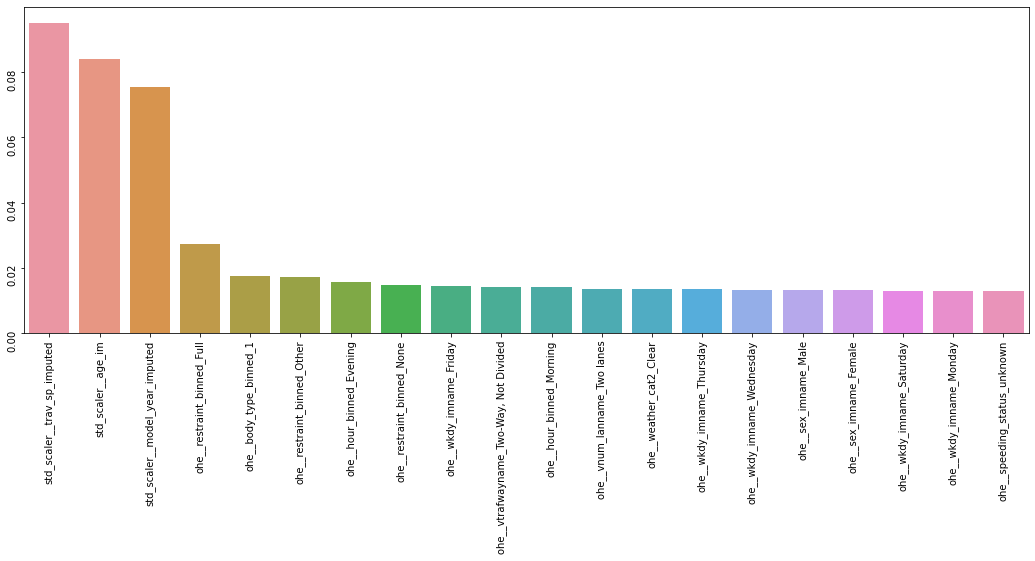

In [28]:
# plots of results. maybe one for each technique

# Random Forest Feature Importance
rf_feature_importances = get_random_forest_feature_importance(dataframe=df, 
                                                              nominal_categorical_features=nominal_categorical_long, 
                                                              numeric_features=numeric, 
                                                              target_column=target)

plot_feature_importances(sorted_importances=rf_feature_importances)

<AxesSubplot:>

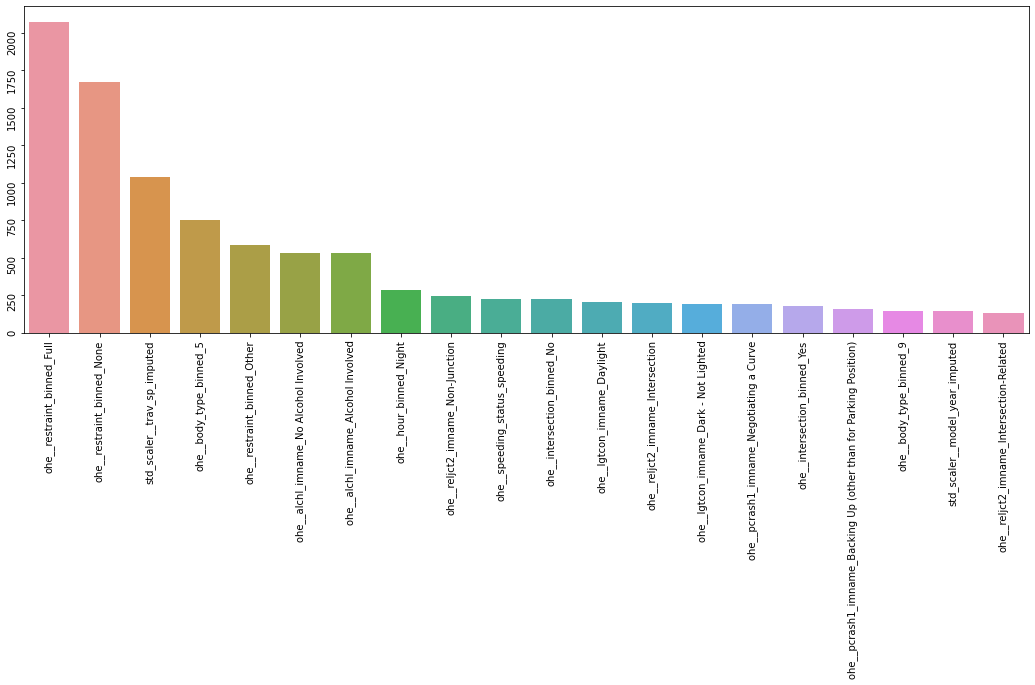

In [30]:
selectkbest_feature_importances = get_selectkbest_importances(dataframe=df, 
                            nominal_categorical_features=nominal_categorical_long, 
                            numeric_features=numeric, 
                            target_column=target,
                            num_best_scores=20)

plot_feature_importances(sorted_importances=selectkbest_feature_importances)

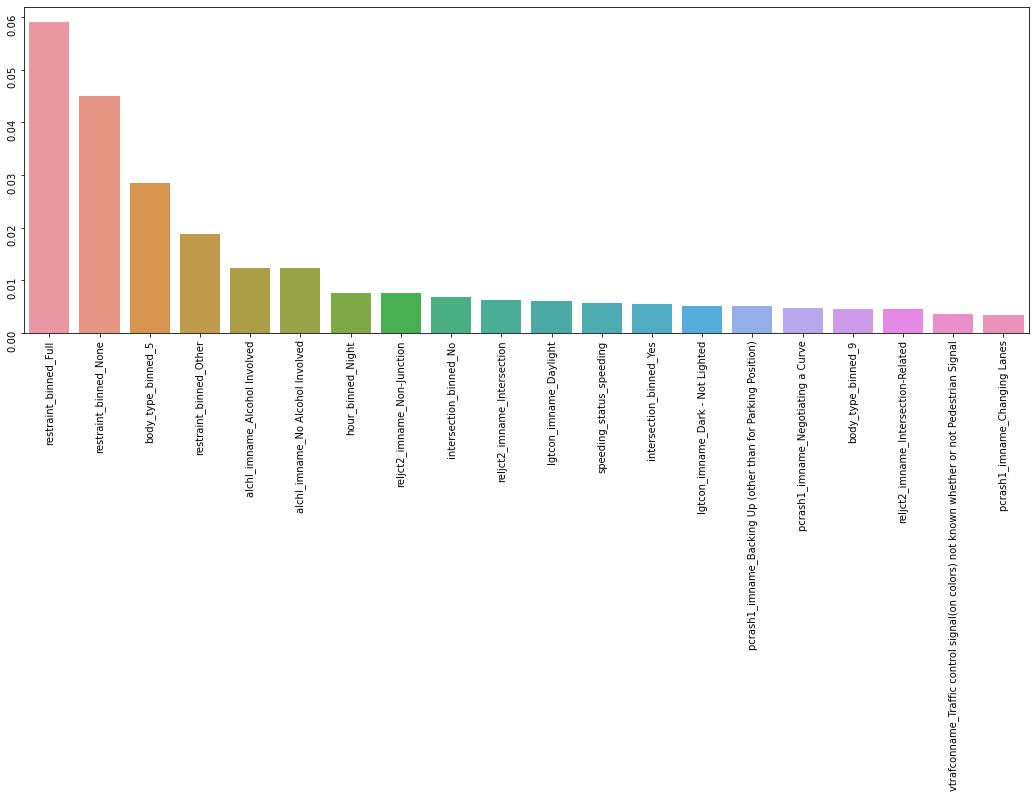

In [40]:
mutual_info_scores = get_mutual_information_importances(dataframe=df, 
                                                        nominal_categorical_features=nominal_categorical_long, 
                                                        target_column=target)

plot_feature_importances(sorted_importances=mutual_info_scores);

# Create Models
Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 50 points.

In [1]:
# code to split train/test data here
# mention that one hot encoded was done inside gridsearch?

## Logistic Regression

Mention hyperparameter tunings here

#### Logistic Regression All Features

In [41]:
LOGREG_GRIDSEARCH_LARGE_PATH="./models/gs_logistic_regression_all_features_06042022.csv"

lr_full_gs_df = pd.read_csv(LOGREG_GRIDSEARCH_LARGE_PATH).sort_values(by="mean_test_accuracy")
lr_full_gs_df.head(1)

,C,penalty,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro
25,0.01,l1,"{'logreg__C': 0.01, 'logreg__penalty': 'l1'}",0.552409,0.008711,26,0.553621,0.00239,0.552409,0.008711,26,0.553621,0.00239,0.324448,0.006795,26,0.326069,0.003007


In [43]:
lr_full_pipe = create_logisic_regression_pipeline(nominal_categorical_features=nominal_categorical_long, 
                                                  numeric_features=numeric, 
                                                  gridsearch_file=LOGREG_GRIDSEARCH_LARGE_PATH)

lr_full_eval = train_and_evaluate_model(model=lr_full_pipe, 
                                        dataframe=full_model_df)

lr_full_train_df=lr_full_eval['train_df']
lr_full_test_df=lr_full_eval['test_df']

================== Training Set Metrics ==================
Accuracy: 0.5706954200254011
Precision: 0.5706954200254011
Recall: 0.5706954200254011
F1: 0.5706954200254011

===================  Test Set Metrics = ==================
Accuracy: 0.5644826871241966
Precision: 0.5644826871241966
Recall: 0.5644826871241966
F1: 0.5644826871241966


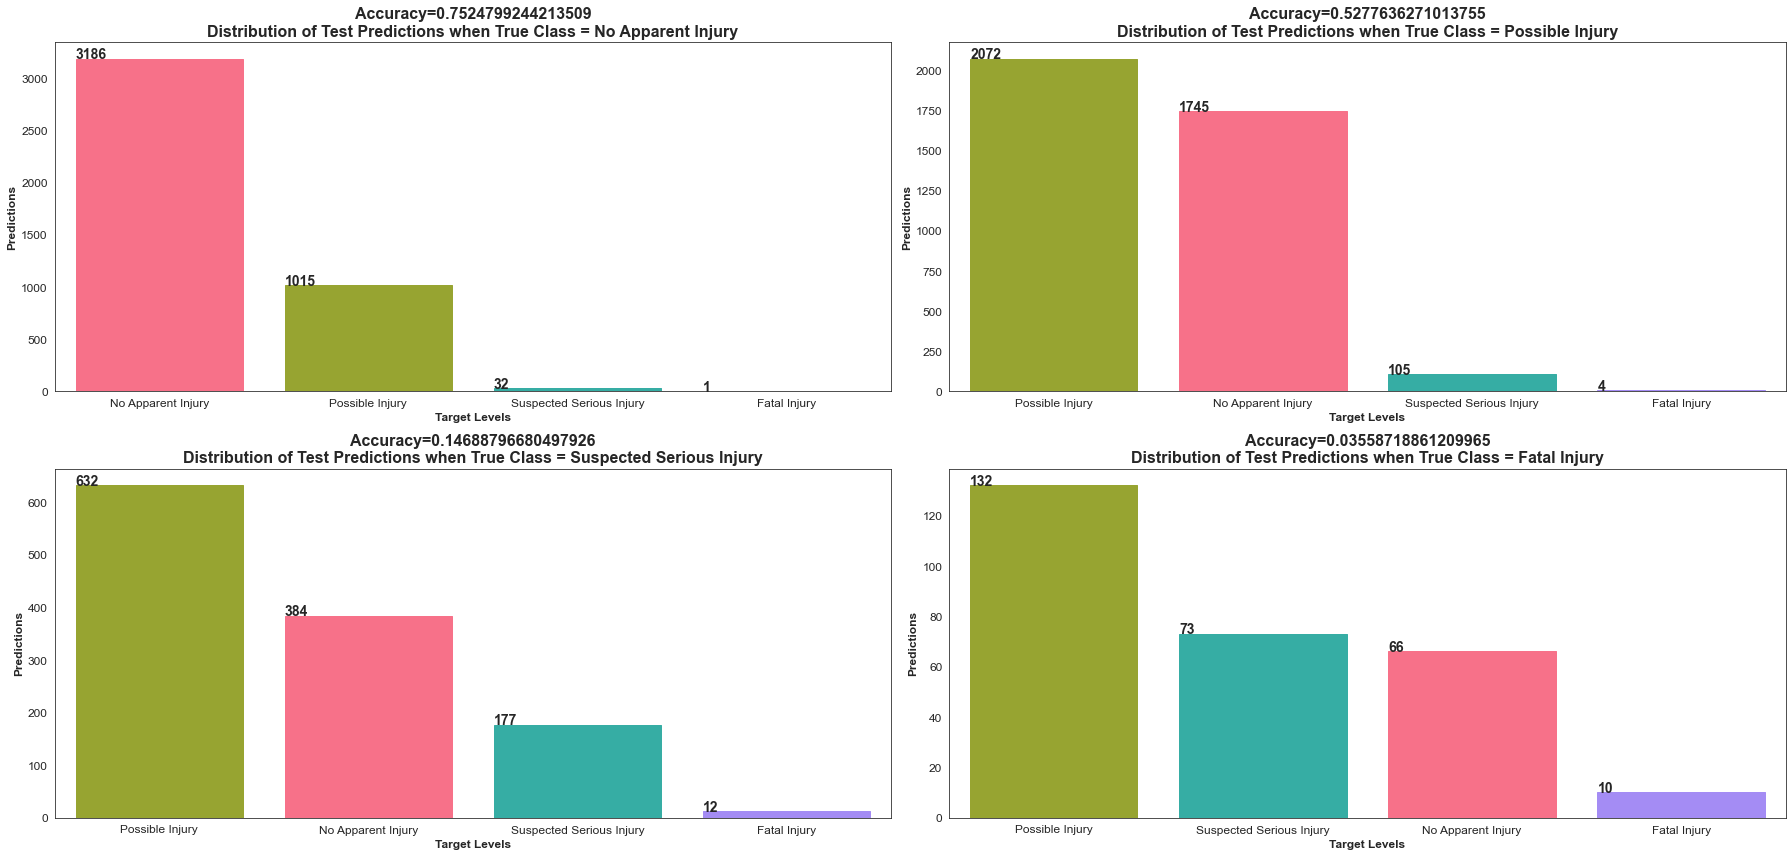

In [46]:
lr_full_count_axis = plot_predictions_by_class(dataframe=lr_full_test_df, 
                                               prediction_column="test_preds")

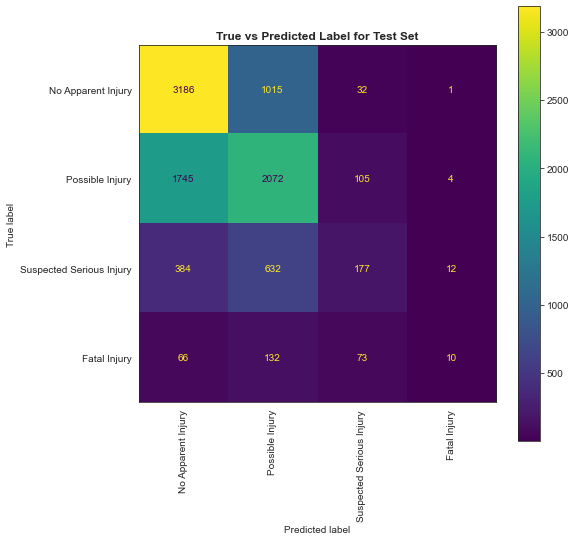

In [47]:
plot_confusion_matrix_by_target_class(dataframe=lr_full_test_df,
                                      prediction_column="test_preds", 
                                      title="True vs Predicted Label for Test Set");

#### Logistic Regression Reduced Features

In [48]:
LOGREG_GRIDSEARCH_PATH="./models/gs_logistic_regression_06042022.csv"

lr_gs_df = pd.read_csv(LOGREG_GRIDSEARCH_PATH).sort_values(by="mean_test_accuracy")
lr_gs_df.head(1)

,C,penalty,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro
25,0.01,l1,"{'logreg__C': 0.01, 'logreg__penalty': 'l1'}",0.552409,0.008711,26,0.553621,0.00239,0.552409,0.008711,26,0.553621,0.00239,0.324448,0.006795,26,0.326069,0.003007


In [49]:
logreg_pipe = create_logisic_regression_pipeline(nominal_categorical_features=nominal_categorical_short, 
                                                 numeric_features=numeric, 
                                                 gridsearch_file=LOGREG_GRIDSEARCH_PATH)

logreg_eval = train_and_evaluate_model(model=logreg_pipe, 
                                       dataframe=model_df)

lr_train_result_df=logreg_eval['train_df']
lr_test_result_df=logreg_eval['test_df']

================== Training Set Metrics ==================
Accuracy: 0.5624271014229802
Precision: 0.5624271014229802
Recall: 0.5624271014229802
F1: 0.5624271014229802

===================  Test Set Metrics = ==================
Accuracy: 0.5559817540949616
Precision: 0.5559817540949616
Recall: 0.5559817540949616
F1: 0.5559817540949616


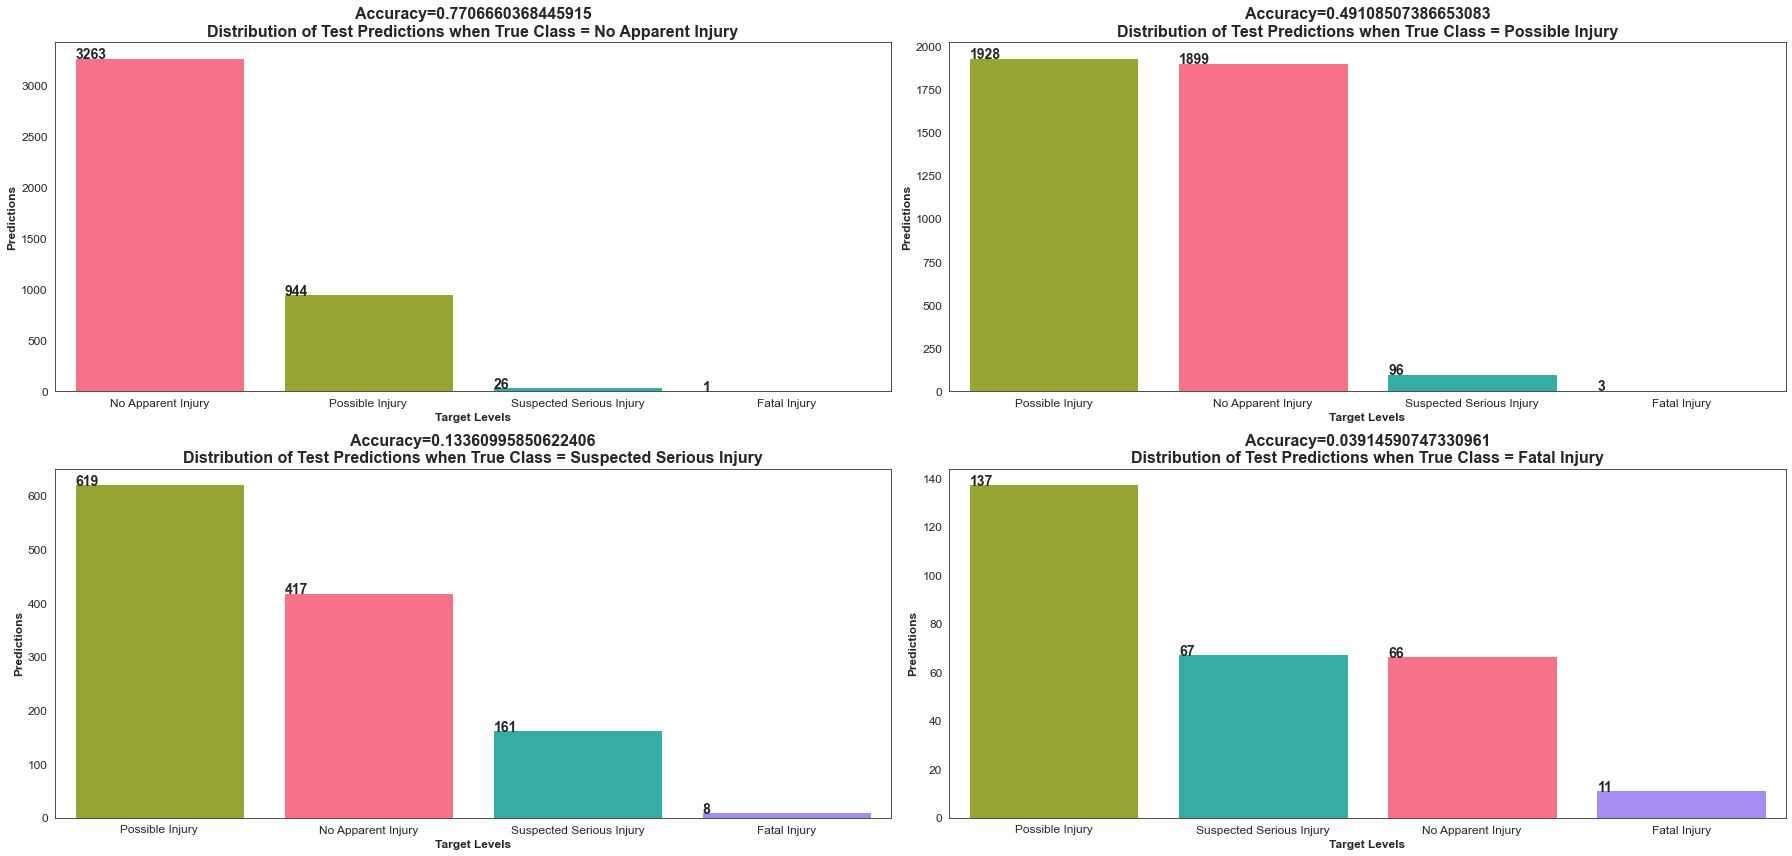

In [51]:
logreg_count_axis = plot_predictions_by_class(dataframe=lr_test_result_df, 
                                              prediction_column="test_preds")

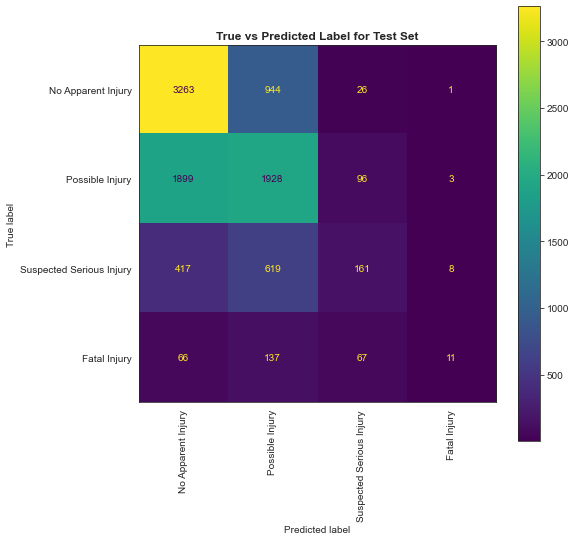

In [52]:
plot_confusion_matrix_by_target_class(dataframe=lr_test_result_df, 
                                      prediction_column="test_preds", 
                                      title="True vs Predicted Label for Test Set");

## Support Vector

Mention hyperparameter tunings here

#### Non-Linear Support Vector Machine

In [53]:
SVM_GRIDSEARCH_PATH = "./models/gs_svm_06042022.csv"

svm_gs_df = pd.read_csv(SVM_GRIDSEARCH_PATH).sort_values(by="mean_test_accuracy")
svm_gs_df.head(1)

,C,gamma,kernel,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro
8,0.05,scale,rbf,"{'svm__C': 0.05, 'svm__gamma': 'scale', 'svm__...",0.549008,0.005768,9,0.552497,0.002187,0.549008,0.005768,9,0.552497,0.002187,0.285164,0.003908,9,0.287164,0.002029


In [ ]:
svm_pipe = create_svm_pipeline(nominal_categorical_features=nominal_categorical_short, 
                               numeric_features=numeric,
                               gridsearch_file=SVM_GRIDSEARCH_PATH)

svm_eval = train_and_evaluate_model(model=svm_pipe, 
                                    dataframe=model_df)

svm_train_result_df = svm_eval['train_df']
svm_test_result_df = svm_eval['test_df']

In [ ]:
svm_count_axis = plot_predictions_by_class(dataframe=svm_test_result_df, prediction_column="test_preds")

In [ ]:
plot_confusion_matrix_by_target_class(dataframe=svm_test_result_df, 
                                      prediction_column="test_preds", 
                                      title="True vs Predicted Label for Test Set");

#### Linear SVM - SGDClassifier

In [ ]:
preprocess = ColumnTransformer(transformers=[("ohe", OneHotEncoder(handle_unknown='infrequent_if_exist'), nominal_categorical), 
                                             ("std_scaler", StandardScaler(), numeric)], 
                                      n_jobs=5)

svm_pipe = Pipeline(steps=[("preprocess", preprocess), 
                            ("svm", SGDClassifier(loss="hinge", 
                                                  n_jobs=5, 
                                                  warm_start=True, 
                                                  random_state=42, 
                                                  average=50, 
                                                  early_stopping=True, 
                                                  max_iter=2_000, 
                                                  n_iter_no_change=100))])

X = model_df.drop(columns=target)
y = model_df[target].to_numpy()

param_grid = [{'svm__penalty':['l1', 'l2'], 
              'svm__eta0':[0.5, 0.1, 0.05, 0.01, 0.005],
              'svm__alpha':[0.000005, 0.00005, 0.0001, 0.0005, 0.005, 0.01], 
              'svm__learning_rate':['adaptive']}, 
              {'svm__penalty':['l1', 'l2'], 
              'svm__alpha':[0.000005, 0.00005, 0.0001, 0.0005, 0.005, 0.01], 
              'svm__learning_rate':['optimal']}, 
              {'svm__penalty':['elasticnet'], 
              'svm__l1_ratio':[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
              'svm__alpha':[0.000001, 0.000005, 0.00005, 0.0001, 0.0005, 0.005, 0.01], 
              'svm__learning_rate':['optimal']}]


#gs = GridSearchCV(estimator=svm_pipe,
#                  param_grid=param_grid,
#                  scoring=["accuracy", "f1_micro", "f1_macro"],
#                  refit="accuracy",
#                  n_jobs=5, 
#                  cv=5,
#                  verbose=3, 
#                  error_score='raise',
#                  return_train_score=True)

#gs.fit(X,y)

#with open("./gs_all_linear_svm_sgd_06042022.pkl", 'wb') as file:
#    pickle.dump(gs, file)

with open("./gs_all_linear_svm_sgd_06042022.pkl", 'wb') as file:
    gs_results = pickle.load(file)

# Model Advantages
Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail. 10 points.

**For report cohesion, this section will be discussed near the end along with our conclusion.**

# Interpret Feature Importance
Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important? 30 points.

In [7]:
# plot of feature importance here

Top five most important features
1. Words 
2. Words
3. Words
4. Words
5. Words

<!-- Continuous feature interpretation:
For every one year increase in age, the estimated odds for fatal injury increased by a multiplicative factor of N, holding all other variables constant. Include practical change in odds if appropriate. 
Categorical feature interpretation:
The estimated odds for a fatal injury with X was N times higher than Y, holding all other variables constant. -->

# Interpret Support Vectors
Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset. 10 points.

In [ ]:
svm_pipe["named_steps"]

In [ ]:
# .support_vectors_

# Model Advantages
Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail. 10 points.

**Logistic regression**
- Faster training time
- More interpretable 
- words

**SVM**
- More complex to better capture signal/trend
- Lower likelihood of bias
- More likely to produce higher prediction accuracy
- words
- words

We theorized that logistic regression would perform worse due to the complexity of our QOI. SVC has higher approximation power and likely discern complex functions. Maybe mention gridsearch time if relevant.

# Conclusion

Report test metrics. Based on these results, it concurred/disagreed with our theory because more words
